In [ ]:
import numpy as np
import pandas as pd
data = pd.read_csv('Dindigul.csv')
print(data.isnull().sum())
data['Hour'] = pd.to_datetime(data['Hour'], format='%H:%M', errors='coerce', exact=False)
# Extract hours and minutes as separate columns
data['Hour_Hour'] = data['Hour'].dt.minute
data['Hour_Minute'] = data['Hour'].dt.hour


Station Code             0
Station Name             0
District                 0
Latitude                 0
Longitude                0
Year                     0
Month                    0
Day                      0
Hour                     0
Min Temperature        219
Max Temperature        127
Temp Dry Bulb           41
Temp Wet Bulb           40
Relative Humidity      143
Inst Wind Speed      27493
Av Wind Speed        26031
Wind direction         317
Pan Evaporation        138
Rainfall               311
dtype: int64


In [ ]:
years = data['Year'].unique()

In [ ]:
years

array([1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2020])

In [ ]:
months = data['Month'].unique()
months

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [ ]:
#seasonal filling for nulls
def seasonal_fill(column):
  c = 0
  yearly = []
  for year in years :
    monthly = []
    for month in range(1,13):
      selected_rows = data[(data['Year'] == year) & (data['Month'] == month)]
      monthly_avg = selected_rows[column].mean()
      data.loc[(data['Year'] == year) & (data['Month'] == month), column] = monthly_avg
      monthly.append(monthly_avg)
    yearly.append(monthly)
  means = []
  for i in range(len(yearly[0])):
    values = []
    for j in range(len(yearly)):
      values.append(yearly[j][i])
    mean = np.nanmean(values)
    means.append(mean)
  print(means)
  for val in range(len(means)):
    data.loc[(data['Month'] == val+1) & (data[column].isna()|data[column].isnull()), column] = means[val]


seasonal_fill('Temp Dry Bulb')
seasonal_fill('Temp Wet Bulb')
seasonal_fill('Relative Humidity')
seasonal_fill('Inst Wind Speed')
seasonal_fill('Rainfall')
seasonal_fill('Av Wind Speed')
seasonal_fill('Pan Evaporation')


[26.1267660707521, 28.131192559834798, 30.498695380569398, 31.730104069405538, 31.223770161290318, 30.003752314814815, 29.54020055657546, 29.265644749346635, 29.027491290795744, 27.862906886528542, 26.468824113308226, 25.638015086080266]
[20.760845681440685, 21.29638045968326, 22.640463818952707, 24.31337962962963, 24.532504480286736, 23.739976851851853, 23.251329880234284, 23.186597359536783, 23.371099239090576, 23.65510708978057, 22.985163817080505, 21.641416505978253]
[61.77046751733464, 55.11047555138827, 51.93389186664044, 54.87488128306879, 57.606009776495625, 57.92893431983386, 57.27614156249089, 58.398964640223085, 61.597521759528895, 70.20036370457791, 74.14923421541185, 69.96823462015422]
[4.112056736585709, 4.26763760593608, 4.5093519822722445, 5.181349885408709, 8.131406830540586, 10.840600098255956, 11.940323132867322, 10.958058415530468, 8.094064147834276, 5.14743908674773, 3.6752255021479154, 3.924742277720772]
[0.21085540694116617, 0.13780019973304908, 0.362051770988139

In [ ]:
data.isnull().sum()

Station Code           0
Station Name           0
District               0
Latitude               0
Longitude              0
Year                   0
Month                  0
Day                    0
Hour                   0
Min Temperature      219
Max Temperature      127
Temp Dry Bulb          0
Temp Wet Bulb          0
Relative Humidity      0
Inst Wind Speed        0
Av Wind Speed          0
Wind direction       317
Pan Evaporation        0
Rainfall               0
Hour_Hour              0
Hour_Minute            0
dtype: int64

In [ ]:
#padding
columns_to_fill = ['Min Temperature', 'Max Temperature','Rainfall']
data[columns_to_fill] = data[columns_to_fill].fillna(method='ffill')


In [ ]:
data.isnull().sum()


Station Code           0
Station Name           0
District               0
Latitude               0
Longitude              0
Year                   0
Month                  0
Day                    0
Hour                   0
Min Temperature        0
Max Temperature        0
Temp Dry Bulb          0
Temp Wet Bulb          0
Relative Humidity      0
Inst Wind Speed        0
Av Wind Speed          0
Wind direction       317
Pan Evaporation        0
Rainfall               0
Hour_Hour              0
Hour_Minute            0
dtype: int64

In [ ]:
#xgboost regressor
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
# Split the dataset into features (X) and the target variable (y)
X = data[[
    "Year",
    "Month",
    "Day",
    "Hour_Hour",
    "Hour_Minute",
    "Rainfall",
    "Min Temperature",
    "Max Temperature",
    "Temp Dry Bulb",
    "Temp Wet Bulb",
    "Relative Humidity",
    "Inst Wind Speed",
    "Av Wind Speed",
    "Pan Evaporation"
]]
y = data['Rainfall']  # Replace 'Rainfall' with the actual target column name

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Gradient Boosting regressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
gb_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = gb_regressor.predict(X_test)

# Evaluate the model
mse_XGB = mean_squared_error(y_test, y_pred)
r2_XGB = r2_score(y_test, y_pred)
mae_XGB = mean_absolute_error(y_test, y_pred)

# Print the evaluation results
print("Mean Squared Error:", mse_XGB)
print("R-squared (R2) Score:", r2_XGB)
print("MAE:",mae_XGB)

Mean Squared Error: 2.412756748993168e-05
R-squared (R2) Score: 0.9999842063511761
MAE: 0.0032915802441815345


In [ ]:
#random forest regressor
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_regressor.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred)
r2_rf = r2_score(y_test, y_pred)
mae_rf = mean_absolute_error(y_test, y_pred)

# Print the evaluation results
print("Mean Squared Error:", mse_rf)
print("R-squared (R2) Score:", r2_rf)
print("mae:", mae_rf)

Mean Squared Error: 4.934513316774124e-12
R-squared (R2) Score: 0.9999999999967699
mae: 2.418014487484179e-08


In [ ]:
#KNN
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize or normalize features (optional but recommended)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and train the KNN model (adjust n_neighbors and other hyperparameters)
k = 7  # Number of neighbors
knn_model = KNeighborsRegressor(n_neighbors=k)
knn_model.fit(X_train, y_train)

# Make predictions
y_pred = knn_model.predict(X_test)

# Evaluate the model
mae_knn = mean_absolute_error(y_test, y_pred)
mse_knn = mean_squared_error(y_test, y_pred)
rmse_knn = mean_squared_error(y_test, y_pred, squared=False)
r2_knn = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae_knn}')
print(f'Mean Squared Error (MSE): {mse_knn}')
print(f'Root Mean Squared Error (RMSE): {rmse_knn}')
print(f'R-squared (R2) Score: {r2_knn}')


Mean Absolute Error (MAE): 0.019432046284738165
Mean Squared Error (MSE): 0.002962757611522677
Root Mean Squared Error (RMSE): 0.05443121908907311
R-squared (R2) Score: 0.9980606104081565


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Mean Absolute Error (MAE): 0.01847918492473838
Mean Squared Error (MSE): 0.03567690430816228
Root Mean Squared Error (RMSE): 0.18888330870715464
R-squared (R2) Score: 0.9769375771217222


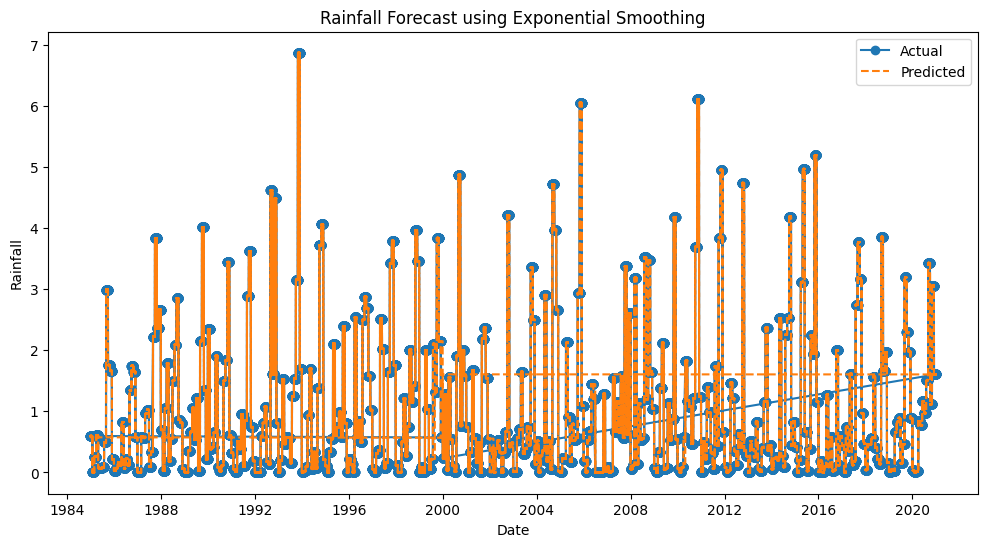

In [ ]:
#Exponential smoothening


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load your dataset

# Assuming you have columns 'Year', 'Month', 'Day', and 'Rainfall'
# Set the date as an index (assuming it's not already)
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data.set_index('Date', inplace=True)

# Extract the 'Rainfall' column as the time series data
rainfall_series = data['Rainfall']

# Apply exponential smoothing
model = ExponentialSmoothing(rainfall_series, seasonal='add', seasonal_periods=7)
model_fit = model.fit()

# Make predictions for the entire time series (including training data)
y_pred = model_fit.fittedvalues

# Calculate metrics for the entire time series
mae_exp = mean_absolute_error(rainfall_series, y_pred)
mse_exp = mean_squared_error(rainfall_series, y_pred)
rmse_exp = np.sqrt(mse_exp)
r2_exp = r2_score(rainfall_series, y_pred)


print(f'Mean Absolute Error (MAE): {mae_exp}')
print(f'Mean Squared Error (MSE): {mse_exp}')
print(f'Root Mean Squared Error (RMSE): {rmse_exp}')
print(f'R-squared (R2) Score: {r2_exp}')

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(rainfall_series.index, rainfall_series, label='Actual', marker='o')
plt.plot(y_pred.index, y_pred, label='Predicted', linestyle='--')
plt.legend()
plt.title('Rainfall Forecast using Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Rainfall')
plt.show()


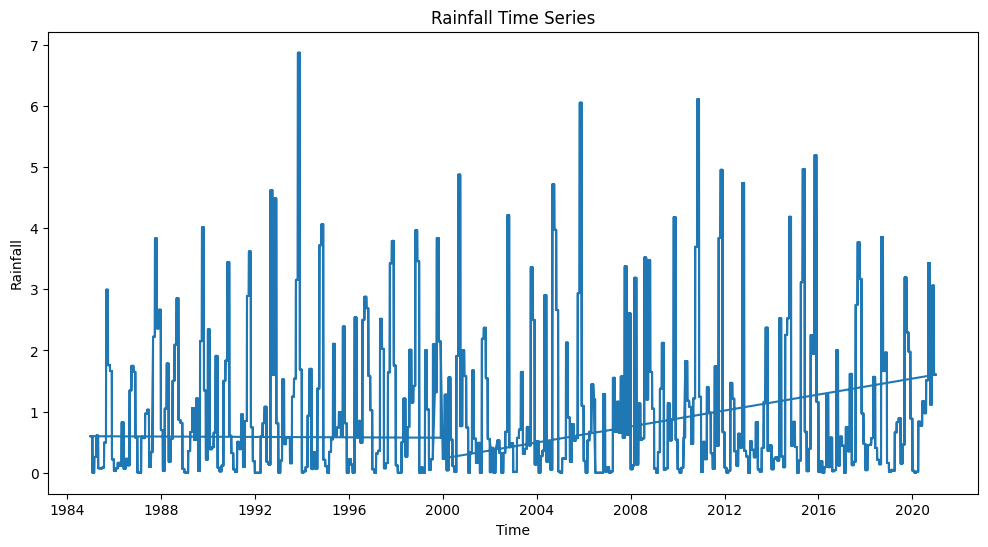

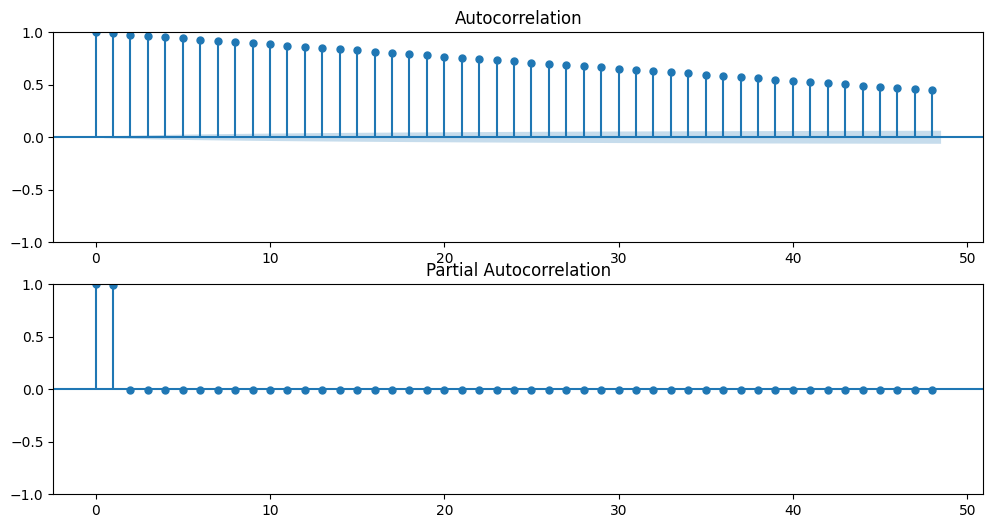

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

                               SARIMAX Results                                
Dep. Variable:               Rainfall   No. Observations:                52139
Model:                 ARIMA(1, 1, 7)   Log Likelihood               12909.771
Date:                Fri, 08 Sep 2023   AIC                         -25801.542
Time:                        13:04:56   BIC                         -25721.787
Sample:                             0   HQIC                        -25776.607
                              - 52139                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       8.642e-08   3.45e-19    2.5e+11      0.000    8.64e-08    8.64e-08
ma.L1      -8.642e-08   3.99e-19  -2.17e+11      0.000   -8.64e-08   -8.64e-08
ma.L2      -8.642e-08   1.16e-13  -7.47e+05      0.0

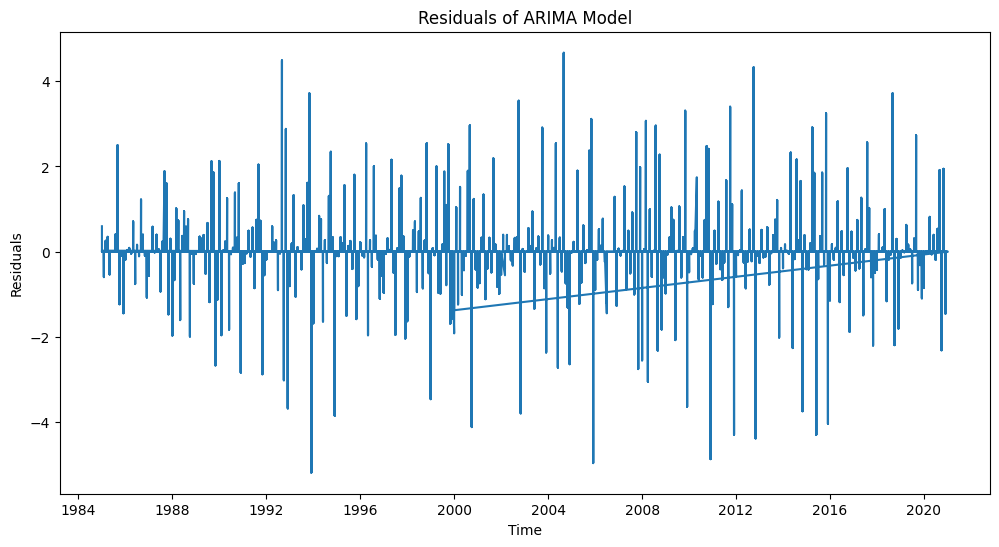

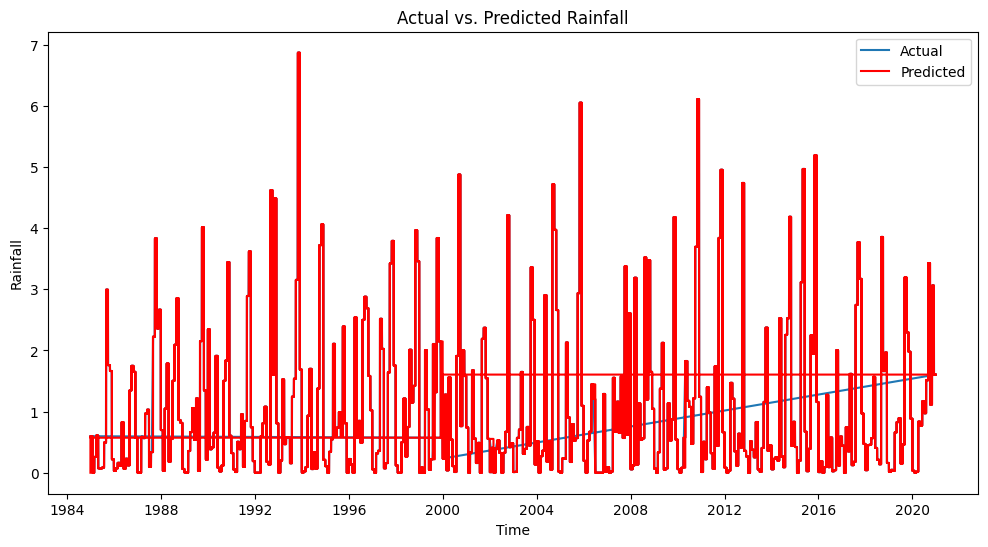

Mean Squared Error (MSE): 0.03568873240787458
Root Mean Squared Error (RMSE): 0.18891461671314527
Mean Absolute Error (MAE): 0.016714727139921597
R-squared (R2) Score: 0.9769299311489927


In [ ]:
#Arima
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



# Combine the year, month, and day columns into a single datetime column
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])

# Add the time information from the 'Hour' column to the datetime column
#data['Date'] += pd.to_timedelta(data['Hour'].astype(str))

# Set the newly created 'Date' column as the index
data.set_index('Date', inplace=True)
# Extract the Rainfall_MovingAverage column as a time series
ts = data['Rainfall']

# Plot the time series data to visualize any trends or seasonality
plt.figure(figsize=(12, 6))
plt.plot(ts)
plt.title('Rainfall Time Series')
plt.xlabel('Time')
plt.ylabel('Rainfall')
plt.show()

# Plot ACF and PACF to determine p and q values for ARIMA
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(ts, ax=ax1)
plot_pacf(ts, ax=ax2)
plt.show()

# Define the ARIMA model with appropriate p, d, and q values
p = 1  # Replace with your chosen value
d = 1 # Replace with your chosen value
q = 7  # Replace with your chosen value

model = ARIMA(ts, order=(p, d, q))

# Fit the ARIMA model
model_fit = model.fit()

# Print a summary of the model
print(model_fit.summary())

# Plot the residuals to check for any patterns
residuals = pd.Series(model_fit.resid)
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# Generate predictions for the test set
# Replace 'start' and 'end' with appropriate indices for your test set
start = 0  # Replace with the start index of your test set
end = len(ts) - 1  # Replace with the end index of your test set
predictions = model_fit.predict(start=start, end=end, typ='levels')

# Plot the actual vs. predicted values for the test set
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Actual')
plt.plot(predictions, label='Predicted', color='red')
plt.title('Actual vs. Predicted Rainfall')
plt.xlabel('Time')
plt.ylabel('Rainfall')
plt.legend()
plt.show()

# Evaluate the model's performance (e.g., calculate RMSE or other metrics)
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import numpy as np

# Generate predictions for the test set (if not already generated)
# Replace 'start' and 'end' with appropriate indices for your test set
start = 0  # Replace with the start index of your test set
end = len(ts) - 1  # Replace with the end index of your test set
predictions = model_fit.predict(start=start, end=end, typ='levels')

# Calculate Mean Squared Error (MSE)
mse_arima = mean_squared_error(ts[start:end+1], predictions)
print("Mean Squared Error (MSE):", mse_arima)

# Calculate Root Mean Squared Error (RMSE)
rmse_arima = np.sqrt(mse_arima)
print("Root Mean Squared Error (RMSE):", rmse_arima)

# Calculate Mean Absolute Error (MAE)
mae_arima = mean_absolute_error(ts[start:end+1], predictions)
print("Mean Absolute Error (MAE):", mae_arima)

# You can also calculate other metrics like R-squared, adjusted R-squared, etc. if needed
r2_arima = r2_score(ts[start:end+1], predictions)
print("R-squared (R2) Score:", r2_arima)


In [ ]:
#LSTM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from ipywidgets import interact
import seaborn as sns
import missingno as msno
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from sklearn.preprocessing import StandardScaler
'''data=pd.read_csv("Dindigal.csv",nrows=14910)
data['Hour'] = pd.to_datetime(data['Hour'], format='%H:%M', errors='coerce', exact=False)

# Extract hours and minutes as separate columns
data['Hour_Hour'] = data['Hour'].dt.hour
data['Hour_Minute'] = data['Hour'].dt.minute
data.reset_index(inplace=True)'''
selected_columns = [
    "Year",
    "Month",
    "Day",
    "Hour_Hour",
    "Hour_Minute",
    "Rainfall",
    "Min Temperature",
    "Max Temperature",
    "Temp Dry Bulb",
    "Temp Wet Bulb",
    "Relative Humidity",
    "Inst Wind Speed",
    "Av Wind Speed",
    "Pan Evaporation"]
import random
# Set a random seed for reproducibility
random.seed(42)

# Subset the data with selected columns
data_subset = data[selected_columns]
dropout_rate = 0.2

# Splitting the data into input (X) and target (y)
X = data_subset.drop("Rainfall", axis=1)
y = data_subset["Rainfall"]

# Normalize the features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Normalize the target variable
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Define sequence length and number of features
sequence_length = 24  # Example: Use 24 hours of data for each sequence
num_features = X_scaled.shape[1]

# Create sequences for LSTM
X_sequences = []
y_sequences = []

for i in range(len(X_scaled) - sequence_length + 1):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y_scaled[i+sequence_length-1])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Split data into train, validation, and test sets
train_size = int(0.7 * len(X_sequences))
val_size = int(0.2 * len(X_sequences))
test_size = len(X_sequences) - train_size - val_size

# Shuffle the data using the same random seed
indices = list(range(len(X_sequences)))
random.shuffle(indices)

# Split the shuffled data
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size+val_size]
test_indices = indices[train_size+val_size:]

X_train, y_train = X_sequences[train_indices], y_sequences[train_indices]
X_val, y_val = X_sequences[val_indices], y_sequences[val_indices]
X_test, y_test = X_sequences[test_indices], y_sequences[test_indices]

model = Sequential([
    LSTM(units=64, input_shape=(sequence_length, num_features), activation='relu', return_sequences=True),
    Dropout(0.2),  # Dropout layer
    LSTM(units=32, activation='relu'),
    Dense(units=1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
loss = model.evaluate(X_test, y_test)

# Make predictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
# Evaluate the model
loss = model.evaluate(X_test, y_test)

# Make predictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")



Epoch 1/50
1141/1141 [==============================] - 38s 31ms/step - loss: 0.3695 - val_loss: 0.2647
Epoch 2/50
1141/1141 [==============================] - 34s 30ms/step - loss: 0.2337 - val_loss: 0.1593
Epoch 3/50
1141/1141 [==============================] - 33s 29ms/step - loss: 0.1419 - val_loss: 0.0845
Epoch 4/50
1141/1141 [==============================] - 35s 30ms/step - loss: 0.0844 - val_loss: 0.0664
Epoch 5/50
1141/1141 [==============================] - 35s 30ms/step - loss: 0.0586 - val_loss: 0.0368
Epoch 6/50
1141/1141 [==============================] - 34s 30ms/step - loss: 0.0487 - val_loss: 0.0328
Epoch 7/50
1141/1141 [==============================] - 34s 30ms/step - loss: 0.0409 - val_loss: 0.0281
Epoch 8/50
1141/1141 [==============================] - 34s 30ms/step - loss: 0.0382 - val_loss: 0.0285
Epoch 9/50
1141/1141 [==============================] - 34s 29ms/step - loss: 0.0256 - val_loss: 0.0244
Epoch 10/50
1141/1141 [==============================] - 34s 30m

In [ ]:
#linear regression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = mean_squared_error(y_test, y_pred, squared=False)
mae_lr = mean_absolute_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse_lr}")
print(f"Root Mean Squared Error (RMSE): {rmse_lr}")
print(f"Mean Absolute Error (MAE): {mae_lr}")
print(f"R-squared (R2): {r2_lr}")

Mean Squared Error (MSE): 0.7555032838438027
Root Mean Squared Error (RMSE): 0.8691969189106705
Mean Absolute Error (MAE): 0.6415883404174627
R-squared (R2): 0.5054555932649415


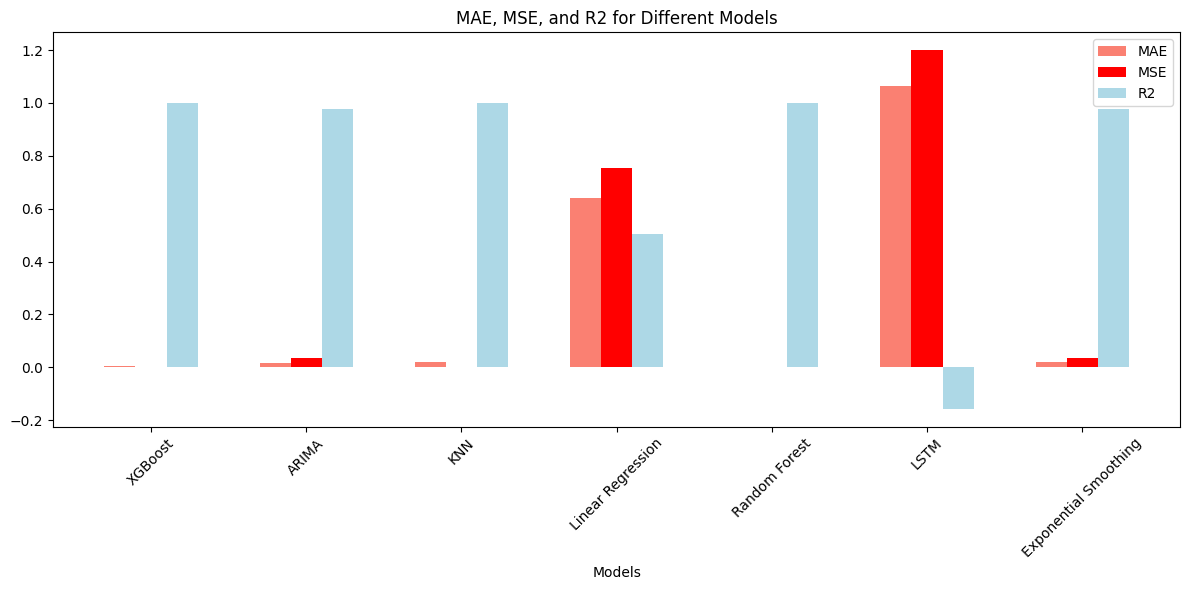

In [ ]:
#comparing all the models
import matplotlib.pyplot as plt
import numpy as np

model_names = ["XGBoost", "ARIMA", "KNN", "Linear Regression", "Random Forest", "LSTM","Exponential Smoothing"]

mae_results = [mae_XGB, mae_arima, mae_knn, mae_lr, mae_rf,mae, mae_exp]
mse_results = [mse_XGB, mse_arima, mse_knn, mse_lr, mse_rf,mse, mse_exp]
r2_results = [r2_XGB, r2_arima, r2_knn, r2_lr, r2_rf, r2,r2_exp]

# Create subplots for MAE, MSE, and R2
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.2
index = np.arange(len(model_names))

ax.bar(index - bar_width, mae_results, bar_width, color='salmon', label='MAE')
ax.bar(index, mse_results, bar_width, color='red', label='MSE')
ax.bar(index + bar_width, r2_results, bar_width, color='lightblue', label='R2')

ax.set_xlabel("Models")
ax.set_title("MAE, MSE, and R2 for Different Models")
ax.set_xticks(index)
ax.set_xticklabels(model_names, rotation=45)
ax.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()